In [1]:
library(jsonlite);packageVersion("jsonlite")
library(tidyverse);packageVersion("tidyverse")

[1] ‘1.8.8’

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] ‘2.0.0’

In [2]:
sampling_fraction <- 0.2
url <- sprintf("https://md.umwelt.info/search/all?query=*&sampling_fraction=%s", sampling_fraction)
dataframe <- stream_in(url(url), pagesize = 10000)

opening url input connection.



 Imported 131911 records. Simplifying...


closing url input connection.



In [3]:
#### Extract quality data

sources <- c("hlnug-he", "umweltatlas-be", "govdata", "thru-de-uba", "website-uba", "umweltchronik-uba",
	"open-umwelt-uba", "ufordat-uba", "flora-web-bfn", "naturdetektive-bfn", "website-bfs",	
	"suche-st",	"umweltportal-sh", "korina-ufu", "metadaten-ufz", "stadt-leipzig")
 
source_num <- 8 # Change to show the plot for the respective source

data <-
    dataframe |> 
    as_tibble() |>
    filter(source == sources[source_num]) |>
    select(quality) |>
    unnest_wider(quality) |>
    unnest(findability, names_sep = "_") |>
    unnest(accessibility, names_sep = "_") |>
    unnest(interoperability, names_sep = "_") |>
    unnest(reusability, names_sep = "_")

data <- data |>
    select(-c("findability_spatial", "findability_identifier", "accessibility_landing_page", "reusability_license"))


In [4]:
#### Preprocess data for the plot creation

data_numeric <- data %>%
  mutate(across(where(is.logical), ~ as.numeric(.)))

translations <- c(
  "title" = "Titel",
  "description" = "Beschreibung",
  "keywords" = "Schlagwörter",
  "spatial_score"= "Raumbezug",
  "temporal" = "Zeitbezug",
  "direct_access"=  "Direktzugriff" ,
  "publicly_accessible"=  "Öffentlich",
  "machine_readable_data" = "Maschinenlesbare Daten",
  "machine_readable_metadata" = "Maschinenlesbare Metadaten",
  "media_type" = "Medientyp",
  "open_file_format" = "Offenes Dateiformat" ,
  "license_score" = "Lizenz" ,
  "contact_info" = "Kontakt" ,
  "publisher_info"= "Veröffentlicher",
  "Findability" = "auffindbar",
  "Accessibility" = "zugänglich",
  "Interoperability" = "interoperabel", 
  "Reusability" =  "wiederverwendbar",
  "landing_page_score" = "Direktlink"
)

group_scores <- data_numeric %>%
  summarize(across(where(is.numeric), mean, na.rm = TRUE)) %>%
  pivot_longer(
    cols = everything(),
    names_to = "category",
    values_to = "mean"
  ) %>%
  filter(category %in% c("findability_score", "accessibility_score", "interoperability_score", "reusability_score")) %>% 
  mutate(
    mean = mean * 100, # Scale the mean values to 0–100
    group = case_when(
      str_detect(category, "findability") ~ "Findability",
      str_detect(category, "accessibility") ~ "Accessibility",
      str_detect(category, "interoperability") ~ "Interoperability",
      str_detect(category, "reusability") ~ "Reusability",
      TRUE ~ "Other"
    ),
    group = str_replace_all(group, translations),
  ) %>%
  select(group, group_mean = mean) 

plot_data <- data_numeric %>%
  summarize(across(where(is.numeric), mean, na.rm = TRUE)) %>%
  pivot_longer(
    cols = everything(),
    names_to = "category",
    values_to = "mean"
  ) %>%
  filter(!category %in% c("findability_score", "accessibility_score", "interoperability_score", "reusability_score", "score")) %>%
  mutate(
    mean = mean * 100, # Scale the mean values to 0–100
    group = case_when(
      str_detect(category, "findability") ~ "Findability",
      str_detect(category, "accessibility") ~ "Accessibility",
      str_detect(category, "interoperability") ~ "Interoperability",
      str_detect(category, "reusability") ~ "Reusability",
      TRUE ~ "Other"
    ),
    id = row_number(),
    source_name = sources[source_num],
    category = case_when(
      category %in% c("findability_score", "accessibility_score", "interoperability_score", "reusability_score") ~ category,
      TRUE ~ str_remove(category, "^(findability|accessibility|interoperability|reusability)_")
    ),
    category = str_replace_all(category, translations),
    group = str_replace_all(group, translations),
    category = str_replace_all(category, " ", "\n"),
    category = str_to_title(category)
  ) %>%
  left_join(group_scores, by = "group") # # Join the group scores back to the main table

score_overall <- mean(data_numeric$score)*100

print(plot_data)

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(where(is.numeric), mean, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


# A tibble: 15 × 6
   category                       mean group           id source_name group_mean
   <chr>                         <dbl> <chr>        <int> <chr>            <dbl>
 1 "Titel"                        15.3 auffindbar       1 ufordat-uba       52.1
 2 "Beschreibung"                 19.0 auffindbar       2 ufordat-uba       52.1
 3 "Raumbezug"                    89.4 auffindbar       3 ufordat-uba       52.1
 4 "Zeitbezug"                   100   auffindbar       4 ufordat-uba       52.1
 5 "Schlagwörter"                 88.9 auffindbar       5 ufordat-uba       52.1
 6 "Verweis"                       0   zugänglich       6 ufordat-uba       33.3
 7 "Direktzugriff"                 0   zugänglich       7 ufordat-uba       33.3
 8 "Öffentlich"                  100   zugänglich       8 ufordat-uba       33.3
 9 "Offenes\nDateiformat"          0   interoperab…     9 ufordat-uba        0  
10 "Medientyp"                     0   interoperab…    10 ufordat-uba        0  
11 "Masch

In [5]:
#### Prepare plot creation plot
empty_bar <- 3
factor_levels <- c("auffindbar", "zugänglich", "interoperabel", "wiederverwendbar")
plot_data$group <- factor(plot_data$group, levels = factor_levels)
plot_data <- plot_data %>%
    arrange(group) %>%
    mutate(id = seq(1, n()))
 
# Get the name and the y position of each label
number_of_bar <- nrow(plot_data)
angle <- 90 - 360 * (plot_data$id-0.5) /number_of_bar  # substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
plot_data$hjust <- ifelse(angle < -90, 1, 0)
plot_data$angle <- ifelse(angle < -90, angle+180, angle)
 
# prepare a data frame for base lines
base_data <- plot_data %>% 
group_by(group, group_mean) %>% 
summarize(start=min(id), end=max(id) - empty_bar) %>% 
rowwise() %>% 
mutate(title=mean(c(start, end))) %>%
mutate(group_score = paste0(group, "\n", round(group_mean, 0), "%"))
 
grid_positions <- c(0, 20, 40, 60, 80, 100)

source_and_score <- paste0(plot_data$source_name, "\n", round(score_overall, 0), "%")

group_colors <- c("#0e59a5", "#aacc00", "#9b5a0e", "#918ae5")

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


Saving 6.67 x 6.67 in image


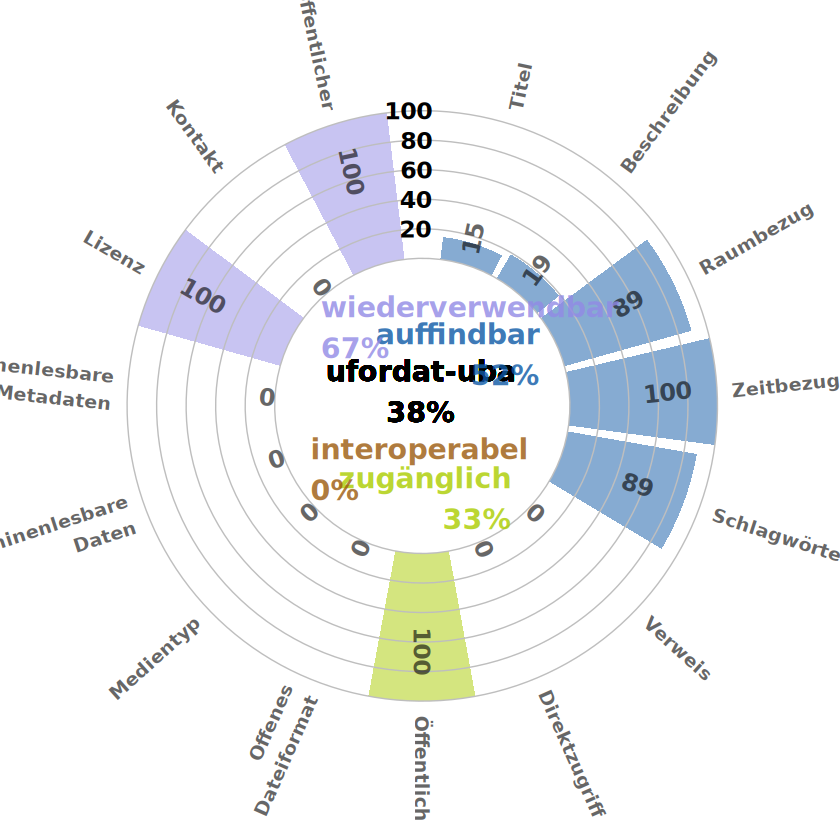

In [6]:
#### Make the plot
p <- ggplot(plot_data, aes(x = as.factor(id), y = mean, fill = group)) +
  geom_bar(aes(x = as.factor(id), y = mean, fill = group), stat = "identity", alpha = 0.5) +
  scale_fill_manual(values = group_colors) +
  geom_hline(yintercept = grid_positions, color = "grey", linetype = "solid", linewidth = 0.4) +
  ylim(-100, 120) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(c(0, 0, 0.5, 0), "cm") 
  ) +
  coord_polar(start = -0.1, clip = "off") +
  geom_text(data = plot_data, aes(x = id, y = 110, label = category, hjust = hjust), 
            color = "black", fontface = "bold", alpha = 0.6, size = 2.5, angle = plot_data$angle, inherit.aes = FALSE) +
  geom_text(data = plot_data, aes(x = id, y = mean / 2, label = round(mean, 0), hjust = hjust), 
            color = "black", fontface = "bold", alpha = 0.6, size = 2.5, angle = plot_data$angle, inherit.aes = FALSE) +
  ggplot2::annotate("text", x = c(0.37, 0.36, 0.35, 0.34, 0.33), y = c(20, 40, 60, 80, 100), 
            label = c("20", "40", "60", "80", "100"), color = "black", size = 3, angle = 0, fontface = "bold", hjust = 1) +
  ggplot2::annotate("text", x = 0, y = -90, label = source_and_score,
            color = "black", fontface = "bold", size = 5, hjust = 0.5) +
  geom_text(data = base_data, aes(x = c(3.1, 6.1, 10.6, 13.5), y = -13, label = group_score, colour = group), 
            hjust = ifelse(base_data$group %in% c("auffindbar", "zugänglich"), 1, 0), 
            alpha = 0.8, size = 4, fontface = "bold", inherit.aes = FALSE) +

  scale_color_manual(values = group_colors)
  print(p)
  ggsave(paste0("barplot_polar_fair_scores_", unique(plot_data$source_name), ".png"))
